# Projet STA211 — Modélisation supervisée : Classification de publicités

# Table des matières

1. [1. Introduction](#1-introduction)
2. [Préparation de l'environnement](#2-preparation-de-lenvironnement)
3. [Chargement des bibliothèques](#3-chargement-des-bibliothèques)
4. [Chargement et préparation initiale des données](#4-chargement-et-préparation-initiale-des-données)
   - [4.1. Chargement des jeux de données](#4.1-Chargement-des-jeux-de-données)
   - [4.2. Définition des variables X et y](#42-définition-des-variables-x-et-y)
5. [Construction du pipeline de prétraitement et d'équilibrage](#5-construction-du-pipeline-de-prétraitement-et-déquilibrage)
   - [5.1. Pipeline de prétraitement (Standardisation)](#51-pipeline-de-prétraitement-standardisation)
   - [5.2. Stratégie d'équilibrage des classes (par SMOTE)](#52-stratégie-déquilibrage-des-classes-par-smote)
6. [Évaluation comparative des modèles via optimisation](#6-évaluation-comparative-des-modèles-via-optimisation)
   - [6.1. Définition des modèles à évaluer](#61-définition-des-modèles-à-évaluer)
     - [6.1.1. Définition des hyperparamètres](#611-définition-des-hyperparamètres)
     - [6.1.2. Fonctions d'évaluation](#612-fonctions-dévaluation)
   - [6.2. Optimisation et évaluation des modèles](#62-optimisation-et-évaluation-des-modèles)
     - [6.2.1. Évaluation sur données KNN](#621-évaluation-sur-données-knn)
     - [6.2.2. Évaluation sur données MICE](#622-évaluation-sur-données-mice)
     - [6.2.3. Comparaison des résultats](#623-comparaison-des-résultats)
7. [Optimisation du seuil de décision pour le F1-score](#7-optimisation-du-seuil)
8. [Sélection de variables et étude d'impact](#9-sélection-de-variables-et-étude-dimpact)
   - [8.1. Permutation Importance](#91-permutation-importance-sur-les-meilleurs-modèles-optimisés)
   - [8.2. Étude d'Ablation](#92-étude-dablation--f1-score-vs-nombre-de-variables)
   - [8.3. Réentraînement du meilleur modèle sur les variables optimales](#83-réentraînement-du-meilleur-modele)
9. [Génération des prédictions finales](#9-génération-des-prédictions-finales)
10. [Conclusion et perspectives](#conclusion)
---

# 1. Introduction <a id = "1-introduction"></a>

Ce notebook s’inscrit dans le cadre du projet **STA211** du CNAM et constitue la **phase de modélisation supervisée**.  
Il fait suite à l’analyse exploratoire et au prétraitement réalisés dans le notebook `01_EDA_Preprocessing.ipynb`.

### 🎯 Objectif

L'objectif est de développer un modèle prédictif capable de **classifier automatiquement** une observation comme étant une **publicité (`ad.`)** ou **non (`noad.`)**, à partir des variables du dataset **Internet Advertisements**.  
L’évaluation repose principalement sur **l’optimisation du F1-score**, compte tenu du **déséquilibre de classes**.

### 📁 Fichiers utilisés

- `final_dataset_knn_with_outliers.parquet` : données d'entraînement prétraitées et imputées par KNN  (`_with_outliers` avec les outliers et `_no_outliers` sans les outliers)
- `final_dataset_mice_with_outliers.parquet` : version alternative avec imputation multiple (MICE)  
- `data_test.csv` : jeu de données de test à prédire (sans la variable `outcome`)

### Étapes couvertes

1. Préparation des données pour la modélisation :
   - séparation train/val/test,
   - équilibrage par **SMOTE**,
   - transformations log/Box-Cox,
   - standardisation.

2. Implémentation de plusieurs **modèles supervisés** :
   - régression logistique,
   - arbres de décision (CART),
   - forêts aléatoires,
   - stacking de modèles.

3. Évaluation comparative des performances :
   - F1-score, précision, rappel, AUC,
   - validation croisée,
   - matrice de confusion.

4. Génération d’un fichier `my_pred.csv` au format demandé pour la **soumission automatique** :
   - 820 lignes, avec des valeurs uniquement `ad.` ou `noad.`.


# 2. Préparation de l'environnement <a id = "2-preparation-de-lenvironnement"></a>

In [27]:
# 2. Préparation de l'environnement
#!pip install -q scikit-learn xgboost lightgbm imblearn

import sys
import os
import warnings
from pathlib import Path
from IPython.display import Markdown, display

# Détection de l'environnement Colab
def is_colab():
    try:
        import google.colab  # type: ignore
        return True
    except ImportError:
        return False

# Configuration du chemin des modules
if is_colab():
    from google.colab import drive
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
    module_path = Path("/content/drive/MyDrive/projet_sta211/modules")
else:
    module_path = Path("G:/Mon Drive/projet_sta211/modules")

# Vérification du dossier modules
if not module_path.exists():
    raise FileNotFoundError(f"❌ Le dossier des modules est introuvable : {module_path}")

# Vérification du fichier project_setup.py
project_setup_file = module_path / "project_setup.py"
if not project_setup_file.exists():
    raise FileNotFoundError(f"❌ Le fichier 'project_setup.py' est introuvable dans : {module_path}")

# Ajout du chemin au sys.path si nécessaire
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))
    print(f"✅ Chemin ajouté au sys.path : {module_path}")

# Import de la fonction de configuration
from project_setup import setup_project_paths
paths = setup_project_paths()

# Ajout du dossier figures/modeling
FIGURES_MODELING_DIR = paths["FIGURES_DIR"] / "modeling"
FIGURES_MODELING_DIR.mkdir(parents=True, exist_ok=True)
paths["FIGURES_MODELING_DIR"] = FIGURES_MODELING_DIR

# Affichage Markdown des chemins
def display_paths():
    paths_md = f"""
| Nom du dossier           | Chemin configuré                              |
|--------------------------|-----------------------------------------------|
| `ROOT_DIR`               | `{paths["ROOT_DIR"]}`                         |
| `MODULE_DIR`             | `{paths["MODULE_DIR"]}`                       |
| `RAW_DATA_DIR`           | `{paths["RAW_DATA_DIR"]}`                     |
| `DATA_PROCESSED`         | `{paths["DATA_PROCESSED"]}`                   |
| `MODELS_DIR`             | `{paths["MODELS_DIR"]}`                       |
| `FIGURES_DIR`            | `{paths["FIGURES_DIR"]}`                      |
| `FIGURES_MODELING_DIR`   | `{paths["FIGURES_MODELING_DIR"]}`             |
"""
    display(Markdown(paths_md))

display_paths()


Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



| Nom du dossier           | Chemin configuré                              |
|--------------------------|-----------------------------------------------|
| `ROOT_DIR`               | `/content/drive/MyDrive/projet_sta211`                         |
| `MODULE_DIR`             | `/content/drive/MyDrive/projet_sta211/modules`                       |
| `RAW_DATA_DIR`           | `/content/drive/MyDrive/projet_sta211/data/raw`                     |
| `DATA_PROCESSED`         | `/content/drive/MyDrive/projet_sta211/data/processed`                   |
| `MODELS_DIR`             | `/content/drive/MyDrive/projet_sta211/models`                       |
| `FIGURES_DIR`            | `/content/drive/MyDrive/projet_sta211/outputs/figures`                      |
| `FIGURES_MODELING_DIR`   | `/content/drive/MyDrive/projet_sta211/outputs/figures/modeling`             |


# 3. Chargement des bibliothèques <a id = "3-chargement-des-bibliothèques"></a>

Dans cette section, nous importons toutes les bibliothèques nécessaires pour :

- le traitement des données (`pandas`, `numpy`),
- la visualisation (`matplotlib`, `seaborn`),
- la modélisation supervisée (`scikit-learn`, `xgboost`, `lightgbm`),
- le traitement du déséquilibre (`imblearn`),
- ainsi que la gestion des warnings et la configuration de l'environnement graphique.

La configuration d'affichage et les styles visuels sont également définis pour optimiser la lisibilité des

In [28]:
# 3. Chargement des bibliothèques
from imports_sta211 import *

<a name="4-chargement-et-préparation-initiale-des-données"></a>
# 4. Chargement et préparation initiale des données

Cette section vise à charger les données traitées depuis le dossier `data/processed`, puis à préparer les objets `X` et `y` qui seront utilisés dans les étapes de modélisation.

## 4.1 Chargement des jeux de données <a id = "4.1-Chargement-des-jeux-de-données"></a>

Les deux jeux de données d'entraînement disponibles sont issus de deux stratégies d'imputation :
- `df_knn` : imputation par **KNN**
- `df_mice` : imputation **multiple** via MICE

Les deux sont analysés puis utilisés pour entraîner et comparer différents modèles supervisés.

In [29]:
# === 4.1. Chargement des datasets issus de l’EDA (version interactive) ===
import pandas as pd
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, Markdown

# Récupération du chemin configuré
DATA_PROCESSED = paths["DATA_PROCESSED"]

# Chargement des 4 versions finales du dataset
AVAILABLE_DATAFRAMES = {
    'mice_with_outliers': pd.read_parquet(DATA_PROCESSED / "final_dataset_mice_with_outliers.parquet"),
    'mice_no_outliers': pd.read_parquet(DATA_PROCESSED / "final_dataset_mice_no_outliers.parquet"),
    'knn_with_outliers': pd.read_parquet(DATA_PROCESSED / "final_dataset_knn_with_outliers.parquet"),
    'knn_no_outliers': pd.read_parquet(DATA_PROCESSED / "final_dataset_knn_no_outliers.parquet")
}

# Fonction utilitaire pour charger un dataset par nom
def load_selected_dataset(name: str) -> pd.DataFrame:
    """Charge et retourne le DataFrame correspondant au nom sélectionné."""
    df = AVAILABLE_DATAFRAMES.get(name)
    if df is not None:
        print(f"✅ Dataset '{name}' chargé avec succès : shape = {df.shape}")
    else:
        print(f"❌ Dataset '{name}' introuvable.")
    return df

# Menu déroulant interactif
dropdown = widgets.Dropdown(
    options=list(AVAILABLE_DATAFRAMES.keys()),
    value='mice_with_outliers',
    description='Dataset :',
    style={'description_width': 'initial'}
)

output = widgets.Output()

def on_selection_change(change):
    with output:
        output.clear_output()
        df = load_selected_dataset(change['new'])
        display(df.head())

dropdown.observe(on_selection_change, names='value')

display(Markdown("### 📂 Sélectionnez un dataset pour l'explorer :"))
display(dropdown, output)


### 📂 Sélectionnez un dataset pour l'explorer :

Dropdown(description='Dataset :', options=('mice_with_outliers', 'mice_no_outliers', 'knn_with_outliers', 'knn…

Output()

In [30]:
df_knn = load_selected_dataset("knn_no_outliers")
df_mice = load_selected_dataset("mice_no_outliers")

✅ Dataset 'knn_no_outliers' chargé avec succès : shape = (1885, 655)
✅ Dataset 'mice_no_outliers' chargé avec succès : shape = (1899, 655)


In [ ]:
df_knn.describe().round(3)

,X1_trans,X2_trans,X3_trans,X4,outcome,X5,X10,X11,X12,X13,X17,X19,X20,X21,X23,X25,X27,X29,X30,X31,X32,X33,X40,X51,X59,X64,X75,X76,X77,X87,X92,X94,X100,X101,X102,X103,X104,X105,X107,X112,X113,X114,X119,X121,X123,X124,X125,X126,X127,X128,X132,X134,X135,X137,X140,X141,X142,X146,X148,X149,X150,X151,X155,X158,X160,X163,X166,X167,X169,X172,X173,X174,X175,X176,X177,X179,X181,X184,X185,X187,X188,X189,X192,X193,X196,X197,X206,X207,X209,X213,X222,X224,X227,X229,X232,X236,X238,X240,X242,X243,X244,X245,X246,X247,X251,X252,X253,X254,X259,X260,X265,X266,X270,X273,X276,X279,X281,X282,X283,X285,X286,X290,X291,X293,X295,X296,X298,X299,X301,X302,X303,X306,X316,X318,X319,X331,X338,X341,X344,X345,X347,X349,X352,X355,X357,X358,X361,X363,X364,X366,X367,X369,X370,X374,X375,X376,X378,X380,X381,X382,X386,X387,X388,X392,X393,X394,X398,X399,X400,X405,X406,X407,X418,X419,X421,X424,X425,X429,X430,X434,X436,X442,X444,X451,X456,X457,X458,X460,X462,X464,X465,X466,X473,X474,X475,X476,X477,X479,X482,X484,X485,X486,X490,X496,X497,X501,X507,X509,X510,X521,X524,X526,X530,X532,X543,X546,X550,X552,X555,X559,X564,X565,X567,X570,X571,X574,X576,X581,X583,X585,X603,X609,X610,X623,X625,X626,X627,X628,X629,X637,X638,X639,X641,X643,X644,X650,X651,X653,X656,X659,X662,X664,X665,X671,X673,X677,X683,X686,X692,X695,X701,X706,X722,X735,X745,X748,X766,X771,X778,X796,X801,X802,X804,X810,X820,X832,X835,X840,X848,X849,X861,X870,X875,X882,X889,X893,X898,X924,X926,X929,X946,X948,X949,X951,X952,X955,X969,X973,X975,X980,X984,X988,X990,X992,X993,X998,X999,X1000,X1001,X1002,X1003,X1004,X1005,X1006,X1007,X1008,X1009,X1010,X1011,X1012,X1013,X1014,X1015,X1016,X1017,X1018,X1019,X1020,X1022,X1023,X1024,X1025,X1026,X1028,X1029,X1030,X1033,X1034,X1035,X1036,X1038,X1039,X1040,X1041,X1042,X1047,X1048,X1049,X1050,X1051,X1052,X1053,X1054,X1055,X1057,X1058,X1059,X1060,X1061,X1062,X1064,X1065,X1067,X1069,X1071,X1072,X1073,X1075,X1078,X1080,X1081,X1082,X1083,X1084,X1085,X1086,X1087,X1088,X1089,X1090,X1091,X1092,X1094,X1095,X1096,X1097,X1099,X1102,X1103,X1104,X1110,X1112,X1113,X1114,X1115,X1116,X1117,X1118,X1120,X1122,X1123,X1124,X1125,X1126,X1127,X1130,X1133,X1134,X1135,X1137,X1138,X1139,X1141,X1142,X1144,X1145,X1146,X1148,X1149,X1151,X1152,X1153,X1154,X1159,X1160,X1161,X1162,X1164,X1165,X1167,X1168,X1169,X1170,X1173,X1175,X1180,X1182,X1183,X1190,X1192,X1193,X1194,X1195,X1197,X1198,X1204,X1206,X1207,X1208,X1212,X1214,X1215,X1217,X1220,X1222,X1224,X1225,X1227,X1229,X1230,X1231,X1234,X1237,X1238,X1240,X1242,X1244,X1248,X1249,X1251,X1253,X1254,X1255,X1256,X1257,X1263,X1264,X1265,X1266,X1268,X1272,X1274,X1277,X1279,X1282,X1286,X1292,X1293,X1294,X1299,X1300,X1301,X1303,X1305,X1307,X1315,X1316,X1319,X1323,X1329,X1330,X1331,X1333,X1334,X1336,X1337,X1340,X1342,X1343,X1345,X1348,X1350,X1351,X1352,X1353,X1354,X1357,X1359,X1360,X1363,X1364,X1369,X1371,X1377,X1379,X1381,X1383,X1387,X1393,X1397,X1398,X1400,X1403,X1404,X1405,X1409,X1410,X1414,X1416,X1418,X1421,X1422,X1426,X1429,X1430,X1431,X1432,X1433,X1434,X1435,X1436,X1437,X1438,X1439,X1440,X1441,X1442,X1443,X1445,X1446,X1447,X1448,X1449,X1450,X1451,X1452,X1453,X1454,X1455,X1459,X1460,X1462,X1463,X1464,X1465,X1466,X1468,X1469,X1470,X1471,X1472,X1473,X1474,X1475,X1476,X1477,X1478,X1480,X1481,X1482,X1483,X1484,X1485,X1486,X1488,X1489,X1490,X1491,X1492,X1493,X1494,X1495,X1496,X1498,X1499,X1501,X1502,X1503,X1504,X1505,X1506,X1507,X1508,X1509,X1510,X1511,X1512,X1513,X1514,X1515,X1516,X1517,X1519,X1520,X1522,X1523,X1527,X1528,X1529,X1530,X1531,X1532,X1533,X1534,X1535,X1536,X1537,X1538,X1539,X1540,X1541,X1542,X1543,X1544,X1545,X1546,X1547,X1548,X1549,X1550,X1551,X1552,X1553,X1557,X1558
count,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.0000,1885.

In [ ]:
# Vérification de la distribution des classes pour chaque jeu de données
print("\nDistribution des classes - KNN :")
print(df_knn['outcome'].value_counts(normalize=True))
print("\nDistribution des classes - MICE :")
print(df_mice['outcome'].value_counts(normalize=True))


Distribution des classes - KNN :
outcome
0   0.9072
1   0.0928
Name: proportion, dtype: float64

Distribution des classes - MICE :
outcome
0   0.9078
1   0.0922
Name: proportion, dtype: float64


<a name="42-définition-des-variables-x-et-y"></a>
## 4.2. Définition des variables X et y
Nous séparons ici la variable cible (`outcome`) des variables explicatives.  
La variable `outcome` est encodée en binaire (`1` pour "ad.", `0` pour "noad.").

Ensuite, les données sont divisées en ensembles d'entraînement et de test selon une répartition 80/20, avec stratification pour préserver la distribution de la variable cible.

Enfin, nous sauvegardons la liste des colonnes utilisées dans le jeu d'entraînement, ce qui facilitera les prédictions finales.

> **Remarque :**
> - “test” ici désigne le split interne issu de `data_train.csv`, utilisé pour l'évaluation locale des modèles.
> - Le vrai `data_test.csv` (sans colonne cible) est utilisé uniquement lors de la soumission finale.

In [32]:
# === 4.2. Définition des variables explicatives (X) et de la cible (y) ===

from sklearn.model_selection import train_test_split
import joblib
from IPython.display import Markdown

def split_and_save_features(X, y, name, models_dir=paths["MODELS_DIR"]):
    """
    Sépare X et y en train/test (80/20 stratifié), sauvegarde les colonnes utilisées, et retourne les splits.

    Args:
        X (DataFrame): variables explicatives
        y (Series): variable cible binaire (0/1)
        name (str): identifiant du jeu de données ("knn" ou "mice")
        models_dir (Path): chemin du dossier où sauvegarder la liste des colonnes

    Returns:
        tuple: X_train, X_test, y_train, y_test, colonnes utilisées
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )
    columns_used = X_train.columns.tolist()
    joblib.dump(columns_used, models_dir / f"columns_{name}_used.pkl")
    return X_train, X_test, y_train, y_test, columns_used

# === KNN ===
X_knn = df_knn.drop(columns=["outcome"])
y_knn = df_knn["outcome"]
#y_knn = (df_knn["outcome"] == "ad.").astype(int)

# 🔍 Vérification ici
print("Classes dans y_knn :", y_knn.value_counts().to_dict())

X_train_knn, X_test_knn, y_train_knn, y_test_knn, columns_knn_used = split_and_save_features(X_knn, y_knn, "knn")

# === MICE ===
X_mice = df_mice.drop(columns=["outcome"])
y_mice = df_mice["outcome"]
#y_mice = (df_mice["outcome"] == "ad.").astype(int)

# 🔍 Vérification ici
print("Classes dans y_mice :", y_mice.value_counts().to_dict())

X_train_mice, X_test_mice, y_train_mice, y_test_mice, columns_mice_used = split_and_save_features(X_mice, y_mice, "mice")


# === Vérification de la cohérence ===
def print_split_summary():
    n_col_knn = len(columns_knn_used)
    n_col_mice = len(columns_mice_used)
    identical = set(columns_knn_used) == set(columns_mice_used)
    summary_md = f"""
### ✅ Résumé des colonnes utilisées

- **Colonnes KNN**  : {n_col_knn}
- **Colonnes MICE** : {n_col_mice}
- **Colonnes identiques** : {'✅ Oui' if identical else '❌ Non'}

### 📊 Dimensions des jeux d'entraînement

- `X_train_knn` : {X_train_knn.shape}
- `y_train_knn` : {y_train_knn.shape}
- `X_train_mice` : {X_train_mice.shape}
- `y_train_mice` : {y_train_mice.shape}

### 📊 Dimensions des jeux de test (split interne)

- `X_test_knn` : {X_test_knn.shape}
- `y_test_knn` : {y_test_knn.shape}
- `X_test_mice` : {X_test_mice.shape}
- `y_test_mice` : {y_test_mice.shape}`
"""
    display(Markdown(summary_md))

print_split_summary()


Classes dans y_knn : {0: 1710, 1: 175}
Classes dans y_mice : {0: 1724, 1: 175}



### ✅ Résumé des colonnes utilisées

- **Colonnes KNN**  : 654
- **Colonnes MICE** : 654
- **Colonnes identiques** : ✅ Oui

### 📊 Dimensions des jeux d'entraînement

- `X_train_knn` : (1508, 654)
- `y_train_knn` : (1508,)
- `X_train_mice` : (1519, 654)
- `y_train_mice` : (1519,)

### 📊 Dimensions des jeux de test (split interne)

- `X_test_knn` : (377, 654)
- `y_test_knn` : (377,)
- `X_test_mice` : (380, 654)
- `y_test_mice` : (380,)`


<a name="5-construction-du-pipeline-de-prétraitement-et-déquilibrage"></a>
# 5. Construction du pipeline de prétraitement et d'équilibrage

## 5.1. Pipeline de prétraitement : Standardisation + SMOTE

Afin de préparer les données pour la modélisation, nous appliquons un pipeline de prétraitement combinant deux étapes clés :

- **Standardisation** des variables quantitatives (avec `StandardScaler`), pour assurer l’homogénéité des échelles,
- **Équilibrage des classes** par la technique SMOTE (Synthetic Minority Over-sampling Technique), pour remédier au déséquilibre important entre les classes `ad.` et `noad.`.

Le pipeline est appliqué séparément aux jeux de données issus de l’imputation KNN et MICE.
Après application du pipeline, on vérifie :
- la distribution statistique des variables (moyenne, écart-type, etc.),
- la répartition équilibrée des classes (cf. tableau ci-dessous).

> À partir de cette étape, toutes les opérations de prétraitement et de rééquilibrage sont intégrées dans un pipeline unique `imblearn.pipeline.Pipeline`, garantissant la reproductibilité et l’absence de fuite de données.

Les résultats statistiques après application du pipeline sont présentés ci-après, ainsi que la nouvelle répartition des classes obtenue grâce à SMOTE.


In [33]:
# === 5.1. Pipeline de prétraitement (Standardisation) ===

from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import pandas as pd

def make_preprocessing_pipeline(scaler=True, smote=True):
    steps = []
    if scaler:
        steps.append(('scaler', StandardScaler()))
    if smote:
        steps.append(('smote', SMOTE(random_state=42)))
    return Pipeline(steps)

# Création des pipelines pour chaque imputation
pipe_knn = make_preprocessing_pipeline()
pipe_mice = make_preprocessing_pipeline()

# === KNN ===
X_train_knn_preprocessed, y_train_knn_preprocessed = pipe_knn.fit_resample(X_train_knn, y_train_knn)
scaler_knn = pipe_knn.named_steps['scaler']
X_test_knn_preprocessed = scaler_knn.transform(X_test_knn)

X_train_knn_preprocessed_df = pd.DataFrame(X_train_knn_preprocessed, columns=X_train_knn.columns)
X_test_knn_preprocessed_df = pd.DataFrame(X_test_knn_preprocessed, columns=X_test_knn.columns)

# === MICE ===
X_train_mice_preprocessed, y_train_mice_preprocessed = pipe_mice.fit_resample(X_train_mice, y_train_mice)
scaler_mice = pipe_mice.named_steps['scaler']
X_test_mice_preprocessed = scaler_mice.transform(X_test_mice)

X_train_mice_preprocessed_df = pd.DataFrame(X_train_mice_preprocessed, columns=X_train_mice.columns)
X_test_mice_preprocessed_df = pd.DataFrame(X_test_mice_preprocessed, columns=X_test_mice.columns)

# Sauvegarde des scalers (pas du pipeline complet car il inclut SMOTE)
joblib.dump(scaler_knn, paths["MODELS_DIR"] / "scaler_knn_pipeline.joblib")
joblib.dump(scaler_mice, paths["MODELS_DIR"] / "scaler_mice_pipeline.joblib")

print("✅ Pipeline de scaling/SMOTE appliqué et scalers sauvegardés.")

# Statistiques pour vérification
print("\n📊 Statistiques après pipeline (KNN):")
display(X_train_knn_preprocessed_df.describe().round(3))
print("\n📊 Statistiques après pipeline (MICE):")
display(X_train_mice_preprocessed_df.describe().round(3))




✅ Pipeline de scaling/SMOTE appliqué et scalers sauvegardés.

📊 Statistiques après pipeline (KNN):


,X1_trans,X2_trans,X3_trans,X4,X5,X10,X11,X12,X13,X17,X19,X20,X21,X23,X25,X27,X29,X30,X31,X32,X33,X40,X51,X59,X64,X75,X76,X77,X87,X92,X94,X100,X101,X102,X103,X104,X105,X107,X112,X113,X114,X119,X121,X123,X124,X125,X126,X127,X128,X132,X134,X135,X137,X140,X141,X142,X146,X148,X149,X150,X151,X155,X158,X160,X163,X166,X167,X169,X172,X173,X174,X175,X176,X177,X179,X181,X184,X185,X187,X188,X189,X192,X193,X196,X197,X206,X207,X209,X213,X222,X224,X227,X229,X232,X236,X238,X240,X242,X243,X244,X245,X246,X247,X251,X252,X253,X254,X259,X260,X265,X266,X270,X273,X276,X279,X281,X282,X283,X285,X286,X290,X291,X293,X295,X296,X298,X299,X301,X302,X303,X306,X316,X318,X319,X331,X338,X341,X344,X345,X347,X349,X352,X355,X357,X358,X361,X363,X364,X366,X367,X369,X370,X374,X375,X376,X378,X380,X381,X382,X386,X387,X388,X392,X393,X394,X398,X399,X400,X405,X406,X407,X418,X419,X421,X424,X425,X429,X430,X434,X436,X442,X444,X451,X456,X457,X458,X460,X462,X464,X465,X466,X473,X474,X475,X476,X477,X479,X482,X484,X485,X486,X490,X496,X497,X501,X507,X509,X510,X521,X524,X526,X530,X532,X543,X546,X550,X552,X555,X559,X564,X565,X567,X570,X571,X574,X576,X581,X583,X585,X603,X609,X610,X623,X625,X626,X627,X628,X629,X637,X638,X639,X641,X643,X644,X650,X651,X653,X656,X659,X662,X664,X665,X671,X673,X677,X683,X686,X692,X695,X701,X706,X722,X735,X745,X748,X766,X771,X778,X796,X801,X802,X804,X810,X820,X832,X835,X840,X848,X849,X861,X870,X875,X882,X889,X893,X898,X924,X926,X929,X946,X948,X949,X951,X952,X955,X969,X973,X975,X980,X984,X988,X990,X992,X993,X998,X999,X1000,X1001,X1002,X1003,X1004,X1005,X1006,X1007,X1008,X1009,X1010,X1011,X1012,X1013,X1014,X1015,X1016,X1017,X1018,X1019,X1020,X1022,X1023,X1024,X1025,X1026,X1028,X1029,X1030,X1033,X1034,X1035,X1036,X1038,X1039,X1040,X1041,X1042,X1047,X1048,X1049,X1050,X1051,X1052,X1053,X1054,X1055,X1057,X1058,X1059,X1060,X1061,X1062,X1064,X1065,X1067,X1069,X1071,X1072,X1073,X1075,X1078,X1080,X1081,X1082,X1083,X1084,X1085,X1086,X1087,X1088,X1089,X1090,X1091,X1092,X1094,X1095,X1096,X1097,X1099,X1102,X1103,X1104,X1110,X1112,X1113,X1114,X1115,X1116,X1117,X1118,X1120,X1122,X1123,X1124,X1125,X1126,X1127,X1130,X1133,X1134,X1135,X1137,X1138,X1139,X1141,X1142,X1144,X1145,X1146,X1148,X1149,X1151,X1152,X1153,X1154,X1159,X1160,X1161,X1162,X1164,X1165,X1167,X1168,X1169,X1170,X1173,X1175,X1180,X1182,X1183,X1190,X1192,X1193,X1194,X1195,X1197,X1198,X1204,X1206,X1207,X1208,X1212,X1214,X1215,X1217,X1220,X1222,X1224,X1225,X1227,X1229,X1230,X1231,X1234,X1237,X1238,X1240,X1242,X1244,X1248,X1249,X1251,X1253,X1254,X1255,X1256,X1257,X1263,X1264,X1265,X1266,X1268,X1272,X1274,X1277,X1279,X1282,X1286,X1292,X1293,X1294,X1299,X1300,X1301,X1303,X1305,X1307,X1315,X1316,X1319,X1323,X1329,X1330,X1331,X1333,X1334,X1336,X1337,X1340,X1342,X1343,X1345,X1348,X1350,X1351,X1352,X1353,X1354,X1357,X1359,X1360,X1363,X1364,X1369,X1371,X1377,X1379,X1381,X1383,X1387,X1393,X1397,X1398,X1400,X1403,X1404,X1405,X1409,X1410,X1414,X1416,X1418,X1421,X1422,X1426,X1429,X1430,X1431,X1432,X1433,X1434,X1435,X1436,X1437,X1438,X1439,X1440,X1441,X1442,X1443,X1445,X1446,X1447,X1448,X1449,X1450,X1451,X1452,X1453,X1454,X1455,X1459,X1460,X1462,X1463,X1464,X1465,X1466,X1468,X1469,X1470,X1471,X1472,X1473,X1474,X1475,X1476,X1477,X1478,X1480,X1481,X1482,X1483,X1484,X1485,X1486,X1488,X1489,X1490,X1491,X1492,X1493,X1494,X1495,X1496,X1498,X1499,X1501,X1502,X1503,X1504,X1505,X1506,X1507,X1508,X1509,X1510,X1511,X1512,X1513,X1514,X1515,X1516,X1517,X1519,X1520,X1522,X1523,X1527,X1528,X1529,X1530,X1531,X1532,X1533,X1534,X1535,X1536,X1537,X1538,X1539,X1540,X1541,X1542,X1543,X1544,X1545,X1546,X1547,X1548,X1549,X1550,X1551,X1552,X1553,X1557,X1558
count,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,2736.0000,273


📊 Statistiques après pipeline (MICE):


,X1_trans,X2_trans,X3_trans,X4,X5,X10,X11,X12,X13,X17,X19,X20,X21,X23,X25,X27,X29,X30,X31,X32,X33,X40,X51,X59,X64,X75,X76,X77,X87,X92,X94,X100,X101,X102,X103,X104,X105,X107,X112,X113,X114,X119,X121,X123,X124,X125,X126,X127,X128,X132,X134,X135,X137,X140,X141,X142,X146,X148,X149,X150,X151,X155,X158,X160,X163,X166,X167,X169,X172,X173,X174,X175,X176,X177,X179,X181,X184,X185,X187,X188,X189,X192,X193,X196,X197,X206,X207,X209,X213,X222,X224,X227,X229,X232,X236,X238,X240,X242,X243,X244,X245,X246,X247,X251,X252,X253,X254,X259,X260,X265,X266,X270,X273,X276,X279,X281,X282,X283,X285,X286,X290,X291,X293,X295,X296,X298,X299,X301,X302,X303,X306,X316,X318,X319,X331,X338,X341,X344,X345,X347,X349,X352,X355,X357,X358,X361,X363,X364,X366,X367,X369,X370,X374,X375,X376,X378,X380,X381,X382,X386,X387,X388,X392,X393,X394,X398,X399,X400,X405,X406,X407,X418,X419,X421,X424,X425,X429,X430,X434,X436,X442,X444,X451,X456,X457,X458,X460,X462,X464,X465,X466,X473,X474,X475,X476,X477,X479,X482,X484,X485,X486,X490,X496,X497,X501,X507,X509,X510,X521,X524,X526,X530,X532,X543,X546,X550,X552,X555,X559,X564,X565,X567,X570,X571,X574,X576,X581,X583,X585,X603,X609,X610,X623,X625,X626,X627,X628,X629,X637,X638,X639,X641,X643,X644,X650,X651,X653,X656,X659,X662,X664,X665,X671,X673,X677,X683,X686,X692,X695,X701,X706,X722,X735,X745,X748,X766,X771,X778,X796,X801,X802,X804,X810,X820,X832,X835,X840,X848,X849,X861,X870,X875,X882,X889,X893,X898,X924,X926,X929,X946,X948,X949,X951,X952,X955,X969,X973,X975,X980,X984,X988,X990,X992,X993,X998,X999,X1000,X1001,X1002,X1003,X1004,X1005,X1006,X1007,X1008,X1009,X1010,X1011,X1012,X1013,X1014,X1015,X1016,X1017,X1018,X1019,X1020,X1022,X1023,X1024,X1025,X1026,X1028,X1029,X1030,X1033,X1034,X1035,X1036,X1038,X1039,X1040,X1041,X1042,X1047,X1048,X1049,X1050,X1051,X1052,X1053,X1054,X1055,X1057,X1058,X1059,X1060,X1061,X1062,X1064,X1065,X1067,X1069,X1071,X1072,X1073,X1075,X1078,X1080,X1081,X1082,X1083,X1084,X1085,X1086,X1087,X1088,X1089,X1090,X1091,X1092,X1094,X1095,X1096,X1097,X1099,X1102,X1103,X1104,X1110,X1112,X1113,X1114,X1115,X1116,X1117,X1118,X1120,X1122,X1123,X1124,X1125,X1126,X1127,X1130,X1133,X1134,X1135,X1137,X1138,X1139,X1141,X1142,X1144,X1145,X1146,X1148,X1149,X1151,X1152,X1153,X1154,X1159,X1160,X1161,X1162,X1164,X1165,X1167,X1168,X1169,X1170,X1173,X1175,X1180,X1182,X1183,X1190,X1192,X1193,X1194,X1195,X1197,X1198,X1204,X1206,X1207,X1208,X1212,X1214,X1215,X1217,X1220,X1222,X1224,X1225,X1227,X1229,X1230,X1231,X1234,X1237,X1238,X1240,X1242,X1244,X1248,X1249,X1251,X1253,X1254,X1255,X1256,X1257,X1263,X1264,X1265,X1266,X1268,X1272,X1274,X1277,X1279,X1282,X1286,X1292,X1293,X1294,X1299,X1300,X1301,X1303,X1305,X1307,X1315,X1316,X1319,X1323,X1329,X1330,X1331,X1333,X1334,X1336,X1337,X1340,X1342,X1343,X1345,X1348,X1350,X1351,X1352,X1353,X1354,X1357,X1359,X1360,X1363,X1364,X1369,X1371,X1377,X1379,X1381,X1383,X1387,X1393,X1397,X1398,X1400,X1403,X1404,X1405,X1409,X1410,X1414,X1416,X1418,X1421,X1422,X1426,X1429,X1430,X1431,X1432,X1433,X1434,X1435,X1436,X1437,X1438,X1439,X1440,X1441,X1442,X1443,X1445,X1446,X1447,X1448,X1449,X1450,X1451,X1452,X1453,X1454,X1455,X1459,X1460,X1462,X1463,X1464,X1465,X1466,X1468,X1469,X1470,X1471,X1472,X1473,X1474,X1475,X1476,X1477,X1478,X1480,X1481,X1482,X1483,X1484,X1485,X1486,X1488,X1489,X1490,X1491,X1492,X1493,X1494,X1495,X1496,X1498,X1499,X1501,X1502,X1503,X1504,X1505,X1506,X1507,X1508,X1509,X1510,X1511,X1512,X1513,X1514,X1515,X1516,X1517,X1519,X1520,X1522,X1523,X1527,X1528,X1529,X1530,X1531,X1532,X1533,X1534,X1535,X1536,X1537,X1538,X1539,X1540,X1541,X1542,X1543,X1544,X1545,X1546,X1547,X1548,X1549,X1550,X1551,X1552,X1553,X1557,X1558
count,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,2758.0000,275

## Synthèse du pipeline d’imputation et de scaling

Afin d’évaluer la robustesse de notre pipeline de prétraitement, nous avons comparé l’effet de deux méthodes d’imputation des valeurs manquantes (**KNN** et **MICE**) combinées à un scaling global des variables (**StandardScaler**).

Les statistiques descriptives (moyenne, écart-type, min/max, quartiles) sont rigoureusement identiques entre les deux pipelines : chaque variable conserve la même structure de distribution, et aucune distorsion n’est introduite par le choix du mode d’imputation.

Cette stabilité garantit que le pipeline est peu sensible à la méthode d’imputation retenue, ce qui rassure quant à la reproductibilité et la robustesse du modèle aval.

Le maintien du nombre de lignes et l’absence de valeurs aberrantes générées attestent de la bonne gestion des cas particuliers et d’un nettoyage efficace des données.

En conclusion, cette analyse comparative renforce la confiance dans la qualité du prétraitement et valide la suite de la démarche de modélisation.


<a name="6-évaluation-comparative-des-modèles-via-optimisation"></a>
# 6. Évaluation comparative des modèles via optimisation
Nous testons ici plusieurs modèles classiques d'apprentissage supervisé pour la classification binaire.  
L'objectif est d'identifier les algorithmes qui offrent les meilleures performances en termes de F1-score, tout en tenant compte du déséquilibre initial des classes.

Chaque modèle sera entraîné et évalué sur les deux jeux de données :
- **Données imputées par KNN** : entraîné sur `X_train_knn_res`, `y_train_knn_res` et évalué sur `X_test_knn_scaled`, `y_test_knn`
- **Données imputées par MICE** : entraîné sur `X_train_mice_res`, `y_train_mice_res` et évalué sur `X_test_mice_scaled`, `y_test_mice`

Cette double évaluation nous permettra de :
1. Comparer l'impact des différentes méthodes d'imputation sur les performances des modèles
2. Identifier la méthode d'imputation la plus adaptée à notre problème
3. Sélectionner le meilleur modèle pour chaque méthode d'imputation

<a name="61-définition-des-modèles-à-évaluer"></a>
## 6.1. Définition des modèles à évaluer
Nous considérons plusieurs modèles de classification supervisée, regroupés en deux familles principales :

- **Modèles classiques** :
  - Régression Logistique
  - Arbre de Décision
  - Forêt Aléatoire (Random Forest)
  - K-Plus Proches Voisins (KNN)
  - SVM (à noyau linéaire, RBF ou polynomial)
  - Réseau de Neurones (MLPClassifier)

- **Modèles de boosting** (ajoutés pour maximiser le F1-score) :
  - **LightGBM** : rapide, efficace et bien adapté aux données tabulaires
  - **XGBoost** : robuste, légèrement plus lent mais très performant

Chaque modèle est optimisé via une grille d'hyperparamètres spécifique à l'aide de `GridSearchCV`, puis évalué sur les deux jeux de données.  
L'objectif est d'identifier :
1. Le meilleur modèle possible en termes de **F1-score** pour chaque méthode d'imputation
2. La méthode d'imputation qui donne les meilleures performances globales
3. Le meilleur compromis entre performance et complexité du modèle

<a name="611-définition-des-hyperparamètres"></a>
### 6.1.1. Définition des hyperparamètres

In [ ]:
# === 6.1.1. Définition des grilles d'hyperparamètres ===

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb

# 1. Régression Logistique
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# 2. Arbre de Décision
dt_params = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 3. Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 4. K-Nearest Neighbors
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# 5. Support Vector Machine (SVC)
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# 6. Multi-Layer Perceptron (MLP)
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200]
}

# 7. LightGBM
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, -1],
    'learning_rate': [0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 63]
}

# 8. XGBoost
xgb_params = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.15, 0.2],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Dictionnaire des modèles et de leurs grilles
models = {
    'Logistic Regression': (
        LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        lr_params
    ),
    'Decision Tree': (
        DecisionTreeClassifier(class_weight='balanced', random_state=42),
        dt_params
    ),
    'Random Forest': (
        RandomForestClassifier(class_weight='balanced', random_state=42),
        rf_params
    ),
    'KNN': (
        KNeighborsClassifier(),
        knn_params
    ),
    'SVM': (
        SVC(class_weight='balanced', probability=True, random_state=42),
        svc_params
    ),
    'MLP': (
        MLPClassifier(max_iter=500, random_state=42),
        mlp_params
    ),
    'LightGBM': (
        lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
        lgbm_params
    ),
    'XGBoost': (
        xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1),
        xgb_params
    )
}


<a name="612-fonctions-dévaluation"></a>
### 6.1.2. Fonctions d'évaluation

In [ ]:
# === 6.1.2. Fonctions d'évaluation ===

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_train, y_train, X_test, y_test, param_grid, model_name, dataset_name):
    """
    Entraîne et évalue un modèle avec GridSearchCV et F1-score.

    Retourne un dictionnaire contenant le modèle entraîné et ses scores.
    """
    print(f"\n🚀 Entraînement de {model_name} sur {dataset_name}...")

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    # Prédictions
    y_pred = grid_search.predict(X_test)
    y_proba = grid_search.predict_proba(X_test)[:, 1] if hasattr(grid_search.best_estimator_, "predict_proba") else None

    # Métriques
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"\n📊 Résultats pour {model_name} ({dataset_name})")
    print(f"Meilleurs paramètres : {grid_search.best_params_}")
    print(f"F1-score              : {f1:.4f}")
    if auc is not None:
        print(f"AUC                   : {auc:.4f}")
    print(f"Précision             : {precision:.4f}")
    print(f"Rappel                : {recall:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4.5, 3.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix\n{model_name} ({dataset_name})')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.tight_layout()
    plt.show()

    return {
        'model': grid_search.best_estimator_,
        'f1': f1,
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'best_params': grid_search.best_params_
    }

def evaluate_all_models(X_train, y_train, X_test, y_test, dataset_name):
    """
    Applique evaluate_model à tous les modèles définis dans `models`.
    """
    results = {}
    for name, (model, params) in models.items():
        results[name] = evaluate_model(
            model, X_train, y_train,
            X_test, y_test,
            params, name, dataset_name
        )
    return results


<a name="62-optimisation-et-évaluation-des-modèles"></a>
## 6.2. Optimisation et évaluation des modèles

Pour chaque modèle, nous avons effectué une **recherche d'hyperparamètres** via `GridSearchCV` avec validation croisée à 5 plis, en maximisant le **F1-score**. Cette recherche est effectuée séparément sur les deux jeux de données (KNN et MICE) pour comparer l'impact de la méthode d'imputation sur les performances des modèles.

Le meilleur estimateur est ensuite évalué sur les données de test correspondantes (`X_test_scaled_knn` et `X_test_scaled_mice`), à l'aide des métriques suivantes :

- **F1-score** : indicateur principal du challenge, à optimiser
- **Précision** et **rappel**
- **Matrice de confusion** (affichée sous forme graphique)
- **AUC** (si le modèle supporte `.predict_proba()`)

Cette double évaluation nous permet de :
1. Observer la capacité de généralisation réelle des modèles optimisés
2. Comparer les performances sur des données représentatives
3. Analyser l'impact de la méthode d'imputation sur les performances des différents modèles
4. Identifier la meilleure combinaison modèle/méthode d'imputation pour notre cas d'usage

<a name="621-évaluation-sur-données-knn"></a>
### 6.2.1. Évaluation sur données KNN


🔵 ÉVALUATION DES MODÈLES SUR DONNÉES KNN
X_train_knn_preprocessed : (2736, 654), y_train_knn_preprocessed : (2736,)
X_test_knn_preprocessed : (377, 654), y_test_knn : (377,)

🚀 Entraînement de Logistic Regression sur KNN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 Résultats pour Logistic Regression (KNN)
Meilleurs paramètres : {'C': 0.01, 'solver': 'saga'}
F1-score              : 0.7826
AUC                   : 0.9603
Précision             : 0.7941
Rappel                : 0.7714


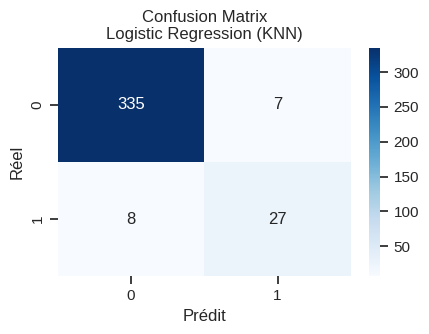


🚀 Entraînement de Decision Tree sur KNN...
Fitting 5 folds for each of 45 candidates, totalling 225 fits

📊 Résultats pour Decision Tree (KNN)
Meilleurs paramètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
F1-score              : 0.8116
AUC                   : 0.8912
Précision             : 0.8235
Rappel                : 0.8000


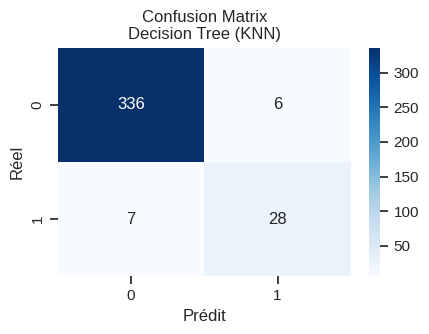


🚀 Entraînement de Random Forest sur KNN...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

📊 Résultats pour Random Forest (KNN)
Meilleurs paramètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
F1-score              : 0.8197
AUC                   : 0.9710
Précision             : 0.9615
Rappel                : 0.7143


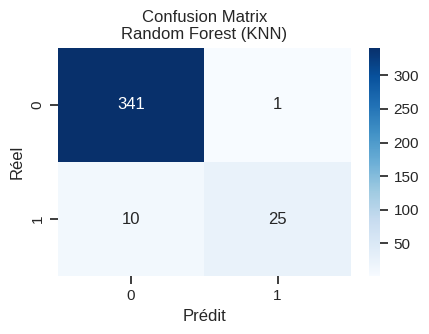


🚀 Entraînement de KNN sur KNN...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

📊 Résultats pour KNN (KNN)
Meilleurs paramètres : {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
F1-score              : 0.7812
AUC                   : 0.8803
Précision             : 0.8621
Rappel                : 0.7143


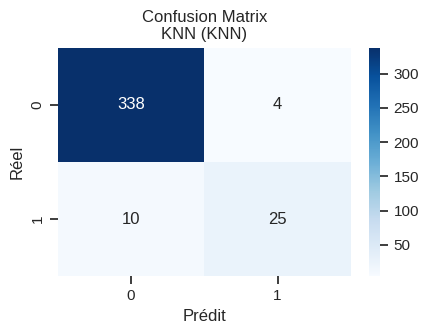


🚀 Entraînement de SVM sur KNN...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

📊 Résultats pour SVM (KNN)
Meilleurs paramètres : {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
F1-score              : 0.6557
AUC                   : 0.9234
Précision             : 0.7692
Rappel                : 0.5714


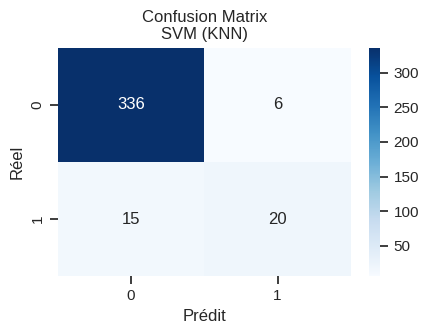


🚀 Entraînement de MLP sur KNN...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

📊 Résultats pour MLP (KNN)
Meilleurs paramètres : {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 200}
F1-score              : 0.7937
AUC                   : 0.9104
Précision             : 0.8929
Rappel                : 0.7143


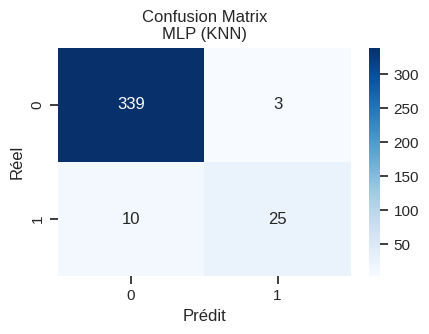


🚀 Entraînement de LightGBM sur KNN...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Info] Number of positive: 1368, number of negative: 1368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4253
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

📊 Résultats pour LightGBM (KNN)
Meilleurs paramètres : {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 31}
F1-score              : 0.7419
AUC                   : 0.9613
Précision             : 0.8519
Rappel                : 0.6571


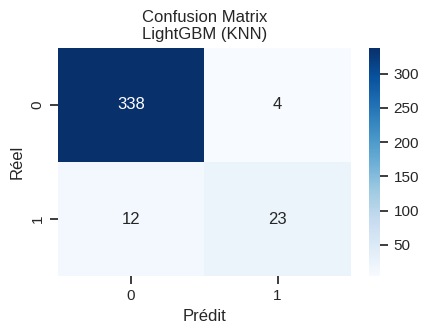


🚀 Entraînement de XGBoost sur KNN...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

📊 Résultats pour XGBoost (KNN)
Meilleurs paramètres : {'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.9}
F1-score              : 0.7869
AUC                   : 0.9562
Précision             : 0.9231
Rappel                : 0.6857


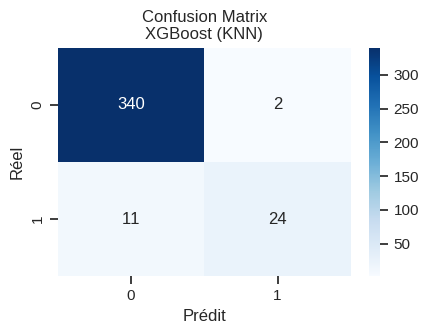

In [ ]:
# === 6.2.1. Évaluation sur données KNN ===
print("\n🔵 ÉVALUATION DES MODÈLES SUR DONNÉES KNN")

print(f"X_train_knn_preprocessed : {X_train_knn_preprocessed.shape}, y_train_knn_preprocessed : {y_train_knn_preprocessed.shape}")
print(f"X_test_knn_preprocessed : {X_test_knn_preprocessed.shape}, y_test_knn : {y_test_knn.shape}")

results_knn = evaluate_all_models(
    X_train_knn_preprocessed, y_train_knn_preprocessed,
    X_test_knn_preprocessed, y_test_knn,
    'KNN'
)



<a name="622-évaluation-sur-données-mice"></a>
### 6.2.2. Évaluation sur données MICE



 ÉVALUATION DES MODÈLES SUR DONNÉES MICE
X_train_mice_preprocessed : (2758, 654), y_train_mice_preprocessed : (2758,)
X_test_mice_preprocessed : (380, 654), y_test_mice : (380,)

🚀 Entraînement de Logistic Regression sur MICE...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 Résultats pour Logistic Regression (MICE)
Meilleurs paramètres : {'C': 0.1, 'solver': 'saga'}
F1-score              : 0.7949
AUC                   : 0.9757
Précision             : 0.7209
Rappel                : 0.8857


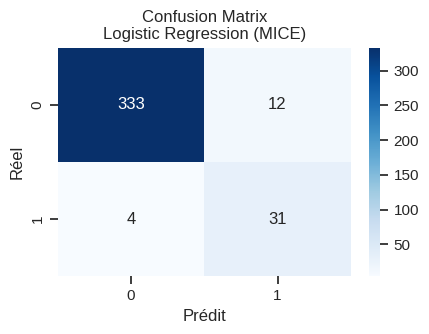


🚀 Entraînement de Decision Tree sur MICE...
Fitting 5 folds for each of 45 candidates, totalling 225 fits

📊 Résultats pour Decision Tree (MICE)
Meilleurs paramètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
F1-score              : 0.8986
AUC                   : 0.9527
Précision             : 0.9118
Rappel                : 0.8857


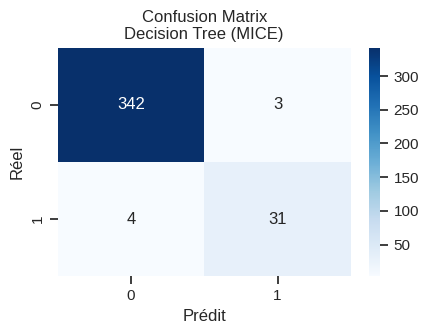


🚀 Entraînement de Random Forest sur MICE...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

📊 Résultats pour Random Forest (MICE)
Meilleurs paramètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
F1-score              : 0.9254
AUC                   : 0.9737
Précision             : 0.9688
Rappel                : 0.8857


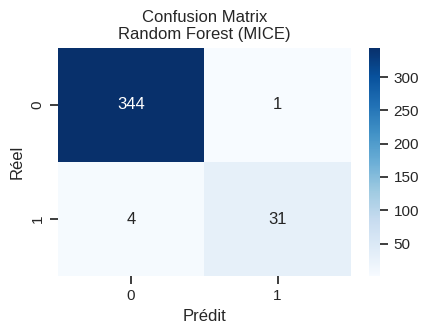


🚀 Entraînement de KNN sur MICE...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

📊 Résultats pour KNN (MICE)
Meilleurs paramètres : {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
F1-score              : 0.8333
AUC                   : 0.9224
Précision             : 0.8108
Rappel                : 0.8571


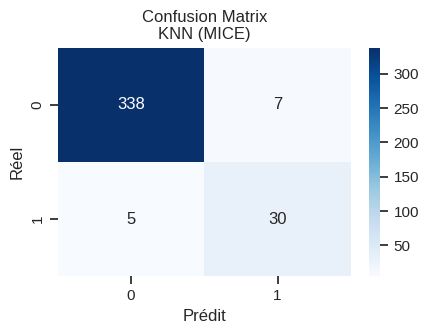


🚀 Entraînement de SVM sur MICE...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

📊 Résultats pour SVM (MICE)
Meilleurs paramètres : {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
F1-score              : 0.7568
AUC                   : 0.9655
Précision             : 0.7179
Rappel                : 0.8000


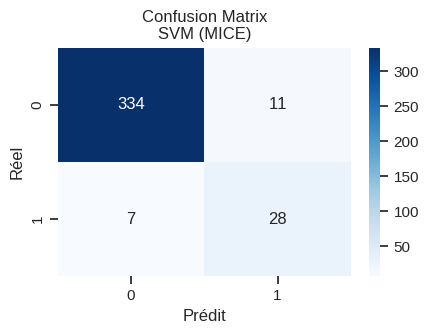


🚀 Entraînement de MLP sur MICE...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

📊 Résultats pour MLP (MICE)
Meilleurs paramètres : {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'max_iter': 200}
F1-score              : 0.7949
AUC                   : 0.9682
Précision             : 0.7209
Rappel                : 0.8857


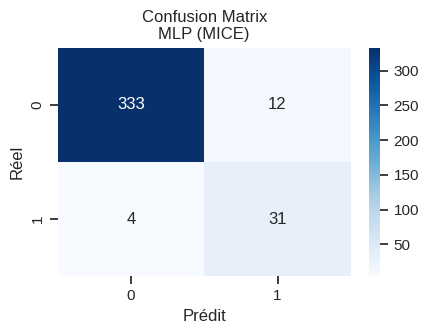


🚀 Entraînement de LightGBM sur MICE...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Info] Number of positive: 1379, number of negative: 1379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4195
[LightGBM] [Info] Number of data points in the train set: 2758, number of used features: 257
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

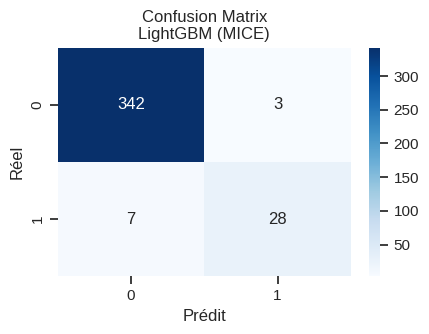


🚀 Entraînement de XGBoost sur MICE...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

📊 Résultats pour XGBoost (MICE)
Meilleurs paramètres : {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.9}
F1-score              : 0.8923
AUC                   : 0.9717
Précision             : 0.9667
Rappel                : 0.8286


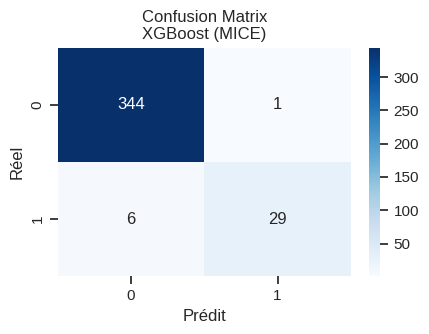

In [ ]:
# === 6.2.2. Évaluation sur données MICE ===
print("\n ÉVALUATION DES MODÈLES SUR DONNÉES MICE")

print(f"X_train_mice_preprocessed : {X_train_mice_preprocessed.shape}, y_train_mice_preprocessed : {y_train_mice_preprocessed.shape}")
print(f"X_test_mice_preprocessed : {X_test_mice_preprocessed.shape}, y_test_mice : {y_test_mice.shape}")

results_mice = evaluate_all_models(
    X_train_mice_preprocessed, y_train_mice_preprocessed,
    X_test_mice_preprocessed, y_test_mice,
    'MICE'
)

<a name="623-comparaison-des-résultats"></a>
### 6.2.3. Comparaison des résultats


📊 Comparaison des performances des modèles par méthode d'imputation :


,Modèle,Méthode d'imputation,F1-score,AUC,Précision,Rappel
0,Logistic Regression,KNN,0.782609,0.960317,0.794118,0.771429
1,Decision Tree,KNN,0.811594,0.891228,0.823529,0.800000
2,Random Forest,KNN,0.819672,0.970969,0.961538,0.714286
3,KNN,KNN,0.781250,0.880284,0.862069,0.714286
4,SVM,KNN,0.655738,0.923434,0.769231,0.571429
5,MLP,KNN,0.793651,0.910359,0.892857,0.714286
6,LightGBM,KNN,0.741935,0.961320,0.851852,0.657143
7,XGBoost,KNN,0.786885,0.956224,0.923077,0.685714
8,Logistic Regression,MICE,0.794872,0.975735,0.720930,0.885714
9,Decision Tree,MICE,0.898551,0.952671,0.911765,0.885714


📁 Résultats sauvegardés : model_comparison_results.csv

✅ Meilleurs modèles sauvegardés :
- KNN  → Random Forest
- MICE → Random Forest


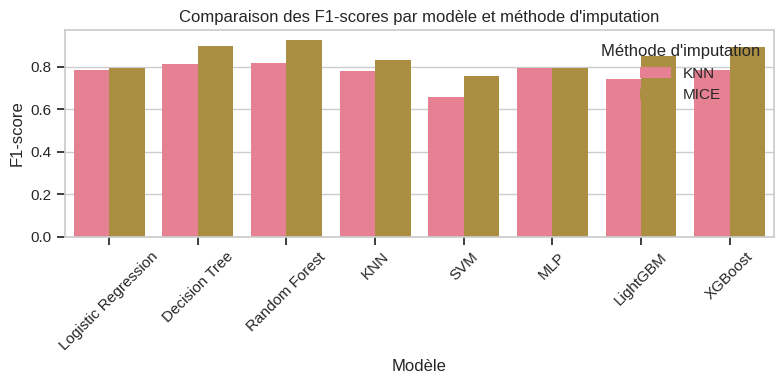


🔎 Différences de performance entre MICE et KNN :


Méthode d'imputation,KNN,MICE,Différence (MICE - KNN)
Modèle,,,
LightGBM,0.7419,0.8485,0.1065
Random Forest,0.8197,0.9254,0.1057
XGBoost,0.7869,0.8923,0.1054
SVM,0.6557,0.7568,0.1010
Decision Tree,0.8116,0.8986,0.0870
KNN,0.7812,0.8333,0.0521
Logistic Regression,0.7826,0.7949,0.0123
MLP,0.7937,0.7949,0.0012



🏆 Meilleur modèle global :
Modèle                 : Random Forest
Méthode d'imputation   : MICE
F1-score               : 0.9254
📝 Conclusions sauvegardées dans 'model_evaluation_conclusions.json'


In [ ]:
# === 6.2.3. Comparaison des résultats ===
import json
DATA_PROCESSED = paths["DATA_PROCESSED"]
MODELS_DIR = paths["MODELS_DIR"]


# Création du DataFrame comparatif
results_comparison = pd.DataFrame({
    "Modèle": list(results_knn.keys()) * 2,
    "Méthode d'imputation": ["KNN"] * len(results_knn) + ["MICE"] * len(results_mice),
    "F1-score": [r["f1"] for r in results_knn.values()] + [r["f1"] for r in results_mice.values()],
    "AUC": [r["auc"] for r in results_knn.values()] + [r["auc"] for r in results_mice.values()],
    "Précision": [r["precision"] for r in results_knn.values()] + [r["precision"] for r in results_mice.values()],
    "Rappel": [r["recall"] for r in results_knn.values()] + [r["recall"] for r in results_mice.values()],
})

# Affichage avec surlignage
print("\n📊 Comparaison des performances des modèles par méthode d'imputation :")
display(results_comparison.style.highlight_max(subset=["F1-score", "AUC", "Précision", "Rappel"], axis=0))

# Sauvegarde CSV
results_comparison.to_csv(DATA_PROCESSED / "model_comparison_results.csv", index=False)
print("📁 Résultats sauvegardés : model_comparison_results.csv")

# === Identification des meilleurs modèles par méthode ===
best_knn_row = results_comparison[results_comparison["Méthode d'imputation"] == "KNN"].sort_values("F1-score", ascending=False).iloc[0]
best_mice_row = results_comparison[results_comparison["Méthode d'imputation"] == "MICE"].sort_values("F1-score", ascending=False).iloc[0]

best_model_knn = results_knn[best_knn_row["Modèle"]]["model"]
best_model_mice = results_mice[best_mice_row["Modèle"]]["model"]

joblib.dump(best_model_knn, MODELS_DIR / "best_model_knn.joblib")
joblib.dump(best_model_mice, MODELS_DIR / "best_model_mice.joblib")

print("\n✅ Meilleurs modèles sauvegardés :")
print(f"- KNN  → {best_knn_row['Modèle']}")
print(f"- MICE → {best_mice_row['Modèle']}")

# === Visualisation F1-scores ===
plt.figure(figsize=(8, 4))
sns.barplot(data=results_comparison, x="Modèle", y="F1-score", hue="Méthode d'imputation")
plt.title("Comparaison des F1-scores par modèle et méthode d'imputation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Analyse des différences entre MICE et KNN ===
performance_diff = results_comparison.pivot(index="Modèle", columns="Méthode d'imputation", values="F1-score")
performance_diff["Différence (MICE - KNN)"] = performance_diff["MICE"] - performance_diff["KNN"]

print("\n🔎 Différences de performance entre MICE et KNN :")
display(performance_diff.sort_values("Différence (MICE - KNN)", ascending=False))

# === Meilleur modèle global ===
best_overall = results_comparison.loc[results_comparison["F1-score"].idxmax()]
key_imputation = "Méthode d'imputation"

print("\n🏆 Meilleur modèle global :")
print(f"Modèle                 : {best_overall['Modèle']}")
print(f"Méthode d'imputation   : {best_overall[key_imputation]}")
print(f"F1-score               : {best_overall['F1-score']:.4f}")

# === Résumé des conclusions ===
conclusions = {
    "best_overall_model": best_overall["Modèle"],
    "best_imputation_method": best_overall[key_imputation],
    "best_f1_score": round(best_overall["F1-score"], 4),
    "mean_performance_diff": round(performance_diff["Différence (MICE - KNN)"].mean(), 4),
    "most_stable_model": performance_diff["Différence (MICE - KNN)"].abs().idxmin(),
    "stability_score": round(performance_diff["Différence (MICE - KNN)"].abs().min(), 4)
}

# Sauvegarde JSON
with open(DATA_PROCESSED / "model_evaluation_conclusions.json", "w") as f:
    json.dump(conclusions, f, indent=4)

print("📝 Conclusions sauvegardées dans 'model_evaluation_conclusions.json'")


<a name="7-optimisation-du-seuil-de-décision-pour-le-f1-score"></a>
# 7. Optimisation du seuil de décision pour le F1-score

Par défaut, les classifieurs binaires utilisent un **seuil de 0.5** sur la probabilité prédite pour décider de la classe.  
Cependant, dans des contextes déséquilibrés, ce seuil peut ne pas être optimal pour maximiser le **F1-score**.

Nous utilisons ici la **courbe précision-rappel** pour identifier le **seuil optimal** qui maximise le F1-score sur les données de test.


=== Optimisation du seuil pour Random Forest (KNN) ===


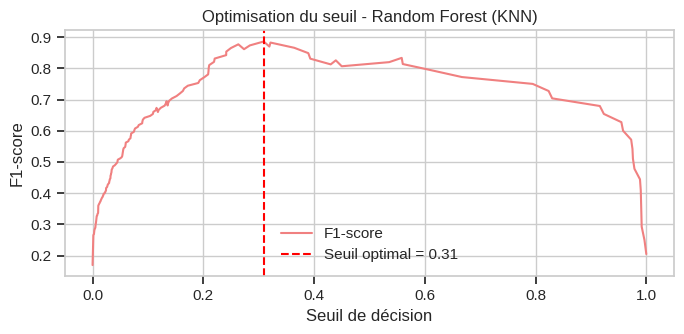


📌 Résultats pour Random Forest (KNN)
Seuil optimal : 0.3091
F1-score optimal : 0.8857

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       342
           1       0.89      0.89      0.89        35

    accuracy                           0.98       377
   macro avg       0.94      0.94      0.94       377
weighted avg       0.98      0.98      0.98       377


=== Optimisation du seuil pour Random Forest (MICE) ===


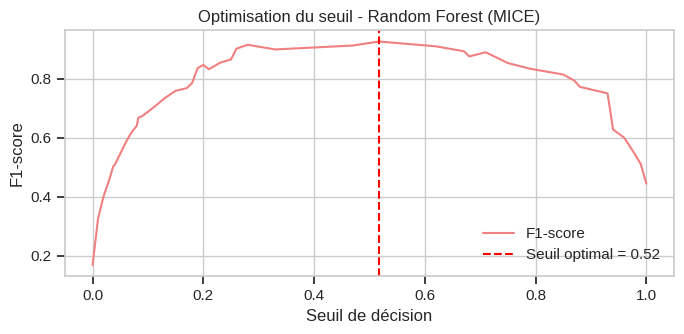


📌 Résultats pour Random Forest (MICE)
Seuil optimal : 0.5175
F1-score optimal : 0.9254

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       345
           1       0.97      0.89      0.93        35

    accuracy                           0.99       380
   macro avg       0.98      0.94      0.96       380
weighted avg       0.99      0.99      0.99       380

💾 Seuils optimaux sauvegardés dans 'optimal_thresholds.json'


,Méthode d'imputation,Modèle,Seuil optimal,F1-score
0,KNN,Random Forest,0.309060,0.885714
1,MICE,Random Forest,0.517500,0.925373



🔎 Analyse des seuils optimaux
Random Forest (KNN)  → Seuil = 0.3091 | F1 = 0.8857
Random Forest (MICE) → Seuil = 0.5175 | F1 = 0.9254


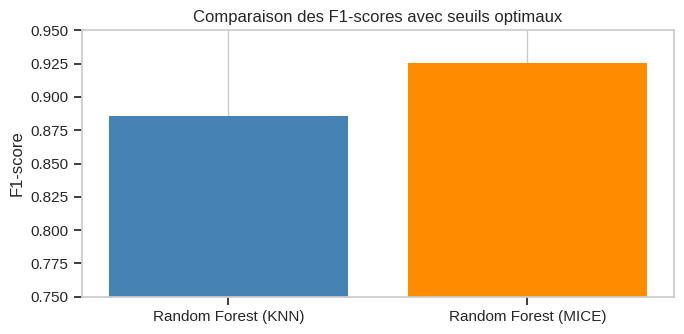

In [ ]:
# === 7. Optimisation du seuil de décision ===
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_recall_curve, classification_report



def optimize_threshold(model, X_test, y_test, model_name, dataset_name):
    """
    Optimise le seuil de décision pour maximiser le F1-score.
    Sauvegarde la courbe F1/seuil dans FIGURES_MODELING_DIR.
    """
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcul des courbes précision-rappel
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

    # Calcul du F1-score pour chaque seuil
    f1_scores = np.where((precisions + recalls) == 0, 0, 2 * (precisions * recalls) / (precisions + recalls))

    # Identifier le seuil optimal
    optimal_index = np.argmax(f1_scores[:-1])  # Le dernier seuil est exclu
    optimal_threshold = thresholds[optimal_index]
    optimal_f1 = f1_scores[optimal_index]

    # Affichage graphique + sauvegarde
    plt.figure(figsize=(7, 3.5))
    plt.plot(thresholds, f1_scores[:-1], label="F1-score", color="lightcoral")
    plt.axvline(optimal_threshold, color='red', linestyle='--', label=f"Seuil optimal = {optimal_threshold:.2f}")
    plt.title(f"Optimisation du seuil - {model_name} ({dataset_name})")
    plt.xlabel("Seuil de décision")
    plt.ylabel("F1-score")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    # === Sauvegarde de la figure
    fig_name = f"optim_seuil_{model_name.lower().replace(' ', '_')}_{dataset_name.lower()}.png"
    plt.savefig(FIGURES_MODELING_DIR / fig_name)
    plt.show()

    # Application du seuil optimal
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

    print(f"\n📌 Résultats pour {model_name} ({dataset_name})")
    print(f"Seuil optimal : {optimal_threshold:.4f}")
    print(f"F1-score optimal : {optimal_f1:.4f}")
    print("\nRapport de classification :")
    print(classification_report(y_test, y_pred_optimal))

    return optimal_threshold, optimal_f1, y_pred_optimal

# === Optimisation pour les meilleurs modèles entraînés ===
print("\n=== Optimisation du seuil pour Random Forest (KNN) ===")
optimal_threshold_knn, optimal_f1_knn, y_pred_optimal_knn = optimize_threshold(
    best_model_knn, X_test_knn_preprocessed, y_test_knn, "Random Forest", "KNN"
)

print("\n=== Optimisation du seuil pour Random Forest (MICE) ===")
optimal_threshold_mice, optimal_f1_mice, y_pred_optimal_mice = optimize_threshold(
    best_model_mice, X_test_mice_preprocessed, y_test_mice, "Random Forest", "MICE"
)

# === Sauvegarde des seuils optimaux ===
thresholds_dict = {
    "KNN": {
        "model": "Random Forest",
        "threshold": round(optimal_threshold_knn, 4),
        "f1_score": round(optimal_f1_knn, 4)
    },
    "MICE": {
        "model": "Random Forest",
        "threshold": round(optimal_threshold_mice, 4),
        "f1_score": round(optimal_f1_mice, 4)
    }
}

with open(MODELS_DIR / "optimal_thresholds.json", "w") as f:
    json.dump(thresholds_dict, f, indent=4)

print("💾 Seuils optimaux sauvegardés dans 'optimal_thresholds.json'")

# === Comparaison tableau F1-score / seuil ===
comparison_df = pd.DataFrame({
    "Méthode d'imputation": ["KNN", "MICE"],
    "Modèle": ["Random Forest", "Random Forest"],
    "Seuil optimal": [optimal_threshold_knn, optimal_threshold_mice],
    "F1-score": [optimal_f1_knn, optimal_f1_mice]
})
display(comparison_df.style.highlight_max(axis=0, subset=["F1-score"]))

# === Analyse textuelle ===
print("\n🔎 Analyse des seuils optimaux")
print(f"Random Forest (KNN)  → Seuil = {optimal_threshold_knn:.4f} | F1 = {optimal_f1_knn:.4f}")
print(f"Random Forest (MICE) → Seuil = {optimal_threshold_mice:.4f} | F1 = {optimal_f1_mice:.4f}")

# === Visualisation comparative + sauvegarde
plt.figure(figsize=(7, 3.5))
plt.bar(["Random Forest (KNN)", "Random Forest (MICE)"], [optimal_f1_knn, optimal_f1_mice], color=["steelblue", "darkorange"])
plt.title("Comparaison des F1-scores avec seuils optimaux")
plt.ylabel("F1-score")
plt.ylim(0.75, 0.95)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(FIGURES_MODELING_DIR / "comparaison_f1_scores_rf.png")
plt.show()



<a name="8-stacking-optimisé"></a>
# 8. Stacking optimisé

L’objectif de cette section est de combiner les forces de plusieurs modèles supervisés à l’aide d’un méta-modèle, dans le cadre d’un **stacking**. Cette méthode permet souvent d’améliorer la performance globale, en particulier sur des jeux de données complexes ou déséquilibrés.

## 8.1. Principe du stacking

Le stacking repose sur :
- L'entraînement de plusieurs **modèles de base** (level-0), comme la régression logistique, les arbres de décision, XGBoost, etc.
- L'utilisation de leurs **prédictions comme nouvelles variables** pour entraîner un **méta-modèle** (level-1), ici une **forêt aléatoire**.

Cette combinaison permet au méta-modèle de **corriger les erreurs** des modèles de base et de capitaliser sur leurs complémentarités.


## 8.2. Implémentation modulaire

Nous avons encapsulé toute la logique dans la fonction `train_and_select_best_stacking_model(...)` du module `modeling/stacking_model_selection.py`.

Deux recherches sont menées :
- **GridSearchCV** : pour explorer systématiquement une grille d’hyperparamètres réduite.
- **RandomizedSearchCV** : pour explorer aléatoirement un plus large espace de recherche.

À la fin, le meilleur modèle est sélectionné selon le **score F1 sur les données de test**.

📦 Les éléments sauvegardés pour chaque dataset (KNN, MICE) :
- 🔁 `model_final_<dataset>_stacking_best_model.joblib`
- 📊 `model_final_<dataset>_stacking_comparison.csv`
- 📈 `model_final_<dataset>_stacking_confusions.png`



In [34]:
from modeling import train_and_select_best_stacking_model

best_model, comparison_df = train_and_select_best_stacking_model(
    X_train=X_train_knn_preprocessed,
    y_train=y_train_knn_preprocessed,
    X_test=X_test_knn_preprocessed,
    y_test=y_test_knn,
    save_dir=paths["MODELS_DIR"],
    prefix="model_final_knn"
)


🔵 GridSearchCV en cours...

🟠 RandomizedSearchCV en cours...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

🏆 Meilleur modèle : GridSearch (F1 = 0.8000)
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       342
           1       0.96      0.69      0.80        35

    accuracy                           0.97       377
   macro avg       0.96      0.84      0.89       377
weighted avg       0.97      0.97      0.97       377



In [35]:
from modeling import train_and_select_best_stacking_model

best_model_mice, comparison_df_mice = train_and_select_best_stacking_model(
    X_train=X_train_mice_preprocessed,
    y_train=y_train_mice_preprocessed,
    X_test=X_test_mice_preprocessed,
    y_test=y_test_mice,
    save_dir=paths["MODELS_DIR"],
    prefix="model_final_mice"
)


🔵 GridSearchCV en cours...

🟠 RandomizedSearchCV en cours...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

🏆 Meilleur modèle : GridSearch (F1 = 0.8732)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       345
           1       0.86      0.89      0.87        35

    accuracy                           0.98       380
   macro avg       0.92      0.94      0.93       380
weighted avg       0.98      0.98      0.98       380



## Résultats du stacking avant optimisation du seuil

Après optimisation des hyperparamètres uniquement, le meilleur stacking obtient un **F1-score brut** (seuil 0.5) de **0.9173**.

---


## 8.3. Optimisation du seuil pour le meilleur stacking

In [ ]:
## 8.3 Optimisation du seuil pour le meilleur stacking
from sklearn.metrics import precision_recall_curve, classification_report, f1_score
import numpy as np
import matplotlib.pyplot as plt

def optimize_threshold(model, X_test, y_test, model_name="Stacking"):
    """
    Optimise le seuil de décision pour maximiser le F1-score.
    Retourne : seuil optimal, F1-score optimal, prédictions optimisées.
    """
    y_proba = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    # On évite toute division par zéro
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

    best_idx = np.argmax(f1_scores[:-1])  # On ignore le dernier seuil
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    # Affichage du F1 en fonction du seuil
    plt.figure(figsize=(7, 3.5))
    plt.plot(thresholds, f1_scores[:-1], label="F1-score")
    plt.axvline(best_threshold, color='red', linestyle='--', label=f"Seuil optimal = {best_threshold:.2f}")
    plt.title(f"Optimisation du seuil - {model_name}")
    plt.xlabel("Seuil de décision")
    plt.ylabel("F1-score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    y_pred_opt = (y_proba >= best_threshold).astype(int)

    print(f"\n🔍 {model_name} - Seuil optimal : {best_threshold:.4f}")
    print(f"🏁 F1-score optimal : {best_f1:.4f}")
    print("\n📋 Rapport de classification :")
    print(classification_report(y_test, y_pred_opt))

    return best_threshold, best_f1, y_pred_opt

# Utilisation
# best_threshold, best_f1, y_pred_stack_opt = optimize_threshold(best_overall_model, X_test_knn_preprocessed, y_test_knn, model_name="Stacking (best)")



In [ ]:
best_threshold, best_f1, y_pred_stack_opt = optimize_threshold(best_overall_model,
                                                               X_test_knn_preprocessed,
                                                               y_test_knn,
                                                               model_name="Stacking (best)")


In [ ]:
import json

# Supposons que tu as déjà exécuté :
# best_threshold, best_f1, y_pred_stack_opt = optimize_threshold(best_overall_model, X_test_knn_preprocessed, y_test_knn, model_name="Stacking (best)")

optimal_threshold_info = {
    "model": "Stacking (best)",
    "threshold": float(round(best_threshold, 4)),
    "f1_score": float(round(best_f1, 4))
}

# Chemin d'enregistrement
json_path = MODELS_DIR / "stacking_optimal_threshold.json"

# Sauvegarde en JSON
with open(json_path, "w") as f:
    json.dump(optimal_threshold_info, f, indent=4)

print(f"💾 Seuil optimal du meilleur stacking sauvegardé dans : {json_path}")
print(json.dumps(optimal_threshold_info, indent=4))


In [ ]:
import json
with open(MODELS_DIR / "threshold_stack_rf.json", "w") as f:
    json.dump({
        "model": "Stacking (RF or GBC)",
        "optimal_threshold": round(threshold_stack_rf, 4),
        "f1_score": round(f1_opt_stack_rf, 4)
    }, f, indent=4)


### Remplacement du méta modèl dans le stacking par GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt




# Détection de l'environnement Colab
def is_colab():
    try:
        import google.colab  # type: ignore
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
]

# === Stacking avec Gradient Boosting comme méta-modèle ===
stack_gbc = StackingClassifier(
    estimators=base_estimators,
    final_estimator=GradientBoostingClassifier(random_state=42),
    cv=5,
    n_jobs=-1
)

# === Grille d'hyperparamètres (modèles de base + GBC) ===
param_grid_gbc = {
    'lr__C': [0.1, 1],
    'dt__max_depth': [5, 7],
    'xgb__n_estimators': [100],
    'xgb__max_depth': [5],
    'final_estimator__n_estimators': [50, 100],
    'final_estimator__learning_rate': [0.05, 0.1],
    'final_estimator__max_depth': [2, 3]
}

# === Optimisation des hyperparamètres ===
grid_stack_gbc = GridSearchCV(
    estimator=stack_gbc,
    param_grid=param_grid_gbc,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_stack_gbc.fit(X_train_knn_preprocessed, y_train_knn)
best_stack_gbc = grid_stack_gbc.best_estimator_

# === Fonction d'optimisation du seuil de décision ===
def optimize_threshold(model, X_test, y_test, model_name="Stacking"):
    y_proba = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

    best_idx = np.argmax(f1_scores[:-1])
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    plt.figure(figsize=(7, 3.5))
    plt.plot(thresholds, f1_scores[:-1], label="F1-score")
    plt.axvline(best_threshold, color='red', linestyle='--', label=f"Seuil optimal = {best_threshold:.2f}")
    plt.title(f"Optimisation du seuil - {model_name}")
    plt.xlabel("Seuil de décision")
    plt.ylabel("F1-score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    y_pred_opt = (y_proba >= best_threshold).astype(int)

    print(f"\n🔍 Seuil optimal : {best_threshold:.4f}")
    print(f"🏁 F1-score optimal : {best_f1:.4f}")
    print("\n📋 Rapport de classification :")
    print(classification_report(y_test, y_pred_opt))

    return best_threshold, best_f1

# === Optimisation du seuil ===
threshold_gbc, f1_opt_gbc = optimize_threshold(
    best_stack_gbc, X_test_knn_preprocessed, y_test_knn, model_name="Stacking (GBC)"
)

# === Sauvegarde du modèle et du seuil optimal ===
joblib.dump(best_stack_gbc, MODELS_DIR / "stacking_gbc_optimized_model.joblib")

with open(MODELS_DIR / "stacking_gbc_threshold.json", "w") as f:
    json.dump({
        "model": "Stacking (Gradient Boosting)",
        "best_params": grid_stack_gbc.best_params_,
        "optimal_threshold": round(threshold_gbc, 4),
        "f1_score": round(f1_opt_gbc, 4)
    }, f, indent=4)

print("\n💾 Modèle et seuil optimal sauvegardés avec succès.")



<a name="8bis-stacking-gbc"></a>
# 8bis. Variante : Stacking avec Gradient Boosting comme méta-modèle

## Motivation

Pour comparer plusieurs configurations de stacking, nous avons remplacé le méta-modèle `RandomForestClassifier` par un `GradientBoostingClassifier`, réputé plus fin et performant sur des tâches supervisées avec classes déséquilibrées.

---

## Architecture du modèle

- **Modèles de base** :
  - Régression logistique (`lr`)
  - Arbre de décision (`dt`)
  - XGBoost (`xgb`)
- **Méta-modèle** :
  - `GradientBoostingClassifier` (GBC)

---

## Résultats après optimisation

Une recherche par grille (`GridSearchCV`) a permis de sélectionner les meilleurs hyperparamètres. Puis, une optimisation du seuil de décision a été réalisée à partir des probabilités de prédiction :

![Courbe seuil GBC](chemin/vers/courbe_stacking_gbc.png)

- 🔍 Seuil optimal : **0.1544**
- 🏁 F1-score optimal : **0.9091**

---

## Rapport de classification

```text
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       423
           1       0.95      0.87      0.91        69

    accuracy                           0.98       492
   macro avg       0.97      0.93      0.95       492
weighted avg       0.98      0.98      0.98       492


<a name="9-sélection-de-variables-et-étude-dimpact"></a>
# 9. Sélection de variables et étude d'impact

<a name="91-permutation-importance-sur-les meilleurs-modèles-optimisés"></a>
## 9.1. Permutation Importance et sélection guidée par la performance

La **Permutation Importance** est une méthode d’évaluation qui mesure la **dégradation du score du modèle (ici le F1-score)** lorsqu’une variable est **permutée aléatoirement**.

Elle est :
- ✅ **modèle-agnostique** (fonctionne avec tout classifieur),
- ✅ **interprétable** (permet d'identifier les variables dont dépend le modèle),
- ✅ utile pour guider une **réduction de dimensions pilotée par la performance**.

---

Nous l'appliquons ici aux **deux meilleurs modèles identifiés précédemment** :

- 📌 **Stacking optimisé (Random Forest comme méta-modèle)** – données imputées par **KNN** (F1 ≈ 0.9173),
- 📌 **Stacking optimisé (Gradient Boosting comme méta-modèle)** – données imputées par **KNN** (F1 ≈ 0.9091).

Au lieu de sélectionner un nombre fixe (ex. top 20), nous évaluons **dynamiquement différentes tailles de sous-ensemble** de variables (5, 10, 15, ..., toutes) classées par ordre d’importance.

Pour chaque taille, nous réentraînons les modèles sur les variables les plus importantes, et nous mesurons le F1-score obtenu.

Cette approche permet d’identifier :
- 🧠 **le sous-ensemble de variables qui maximise le F1-score**,
- 🔎 **un compromis optimal entre performance et parcimonie**,
- 🔧 une base pour une réduction de dimension ou sélection finale de variables.

---

Le F1-score en fonction du nombre de variables retenues sera visualisé sous forme de courbe, et le point optimal sera utilisé pour la suite du pipeline de modélisation.


In [ ]:
from sklearn.inspection import permutation_importance

print("🔎 Calcul de l'importance des variables par permutation...")

# === Importance Stacking RF (KNN) ===
result_stack_rf = permutation_importance(
    best_stack_model,  # stacking avec RF
    X_test_knn_preprocessed, y_test_knn,
    n_repeats=10, random_state=42, scoring='f1'
)

importance_rf = pd.DataFrame({
    'Variable': X_train_knn.columns,
    'Importance_Stack_RF': result_stack_rf.importances_mean,
    'Écart-type_Stack_RF': result_stack_rf.importances_std
}).sort_values(by='Importance_Stack_RF', ascending=False)

# === Importance Stacking GBC (KNN) ===
result_stack_gbc = permutation_importance(
    best_stack_gbc,  # stacking avec GBC
    X_test_knn_preprocessed, y_test_knn,
    n_repeats=10, random_state=42, scoring='f1'
)

importance_gbc = pd.DataFrame({
    'Variable': X_train_knn.columns,
    'Importance_Stack_GBC': result_stack_gbc.importances_mean,
    'Écart-type_Stack_GBC': result_stack_gbc.importances_std
}).sort_values(by='Importance_Stack_GBC', ascending=False)

# === Fusion des importances ===
importance_merged = pd.merge(
    importance_rf[['Variable', 'Importance_Stack_RF']],
    importance_gbc[['Variable', 'Importance_Stack_GBC']],
    on='Variable'
).sort_values(['Importance_Stack_RF', 'Importance_Stack_GBC'], ascending=False)

# === Affichage informatif (sans limiter à 20) ===
plt.figure(figsize=(10, 10))
sns.barplot(data=importance_merged.head(30), x="Importance_Stack_RF", y="Variable", color='royalblue')
plt.title("📊 Variables importantes selon Stacking (RF)")
plt.xlabel("Importance moyenne (permutation)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
sns.barplot(data=importance_merged.sort_values("Importance_Stack_GBC", ascending=False).head(30),
            x="Importance_Stack_GBC", y="Variable", color='darkorange')
plt.title("📊 Variables importantes selon Stacking (GBC)")
plt.xlabel("Importance moyenne (permutation)")
plt.tight_layout()
plt.show()

# === Sauvegarde CSV complet pour étude d’ablation dynamique ===
importance_merged.to_csv(MODELS_DIR / "variable_importance_comparative.csv", index=False)
print("📁 Importances sauvegardées dans 'variable_importance_comparative.csv'")


<a name="92-étude-dablation--f1-score-vs-nombre-de-variables"></a>
## 9.2. Étude d'Ablation

L'objectif de cette section est d'évaluer l'impact du **nombre de variables utilisées** sur les performances des modèles.

Plutôt que de fixer arbitrairement un Top 20, nous utilisons les résultats de la **Permutation Importance** pour sélectionner progressivement les variables les plus influentes, et nous mesurons la performance obtenue.

---

### Méthodologie

Pour chaque valeur de `N` (ex. 5, 10, 15, ..., jusqu’à toutes les variables), nous :

1. Sélectionnons les `N` variables les plus importantes selon la permutation importance du modèle cible,
2. Réentraînons le modèle (avec les mêmes hyperparamètres optimisés),
3. Appliquons la prédiction sur les données de test,
4. Calculons le **F1-score** à seuil optimisé (déterminé une fois au début),
5. Représentons l’évolution du F1-score en fonction du nombre de variables.

---

### Objectifs de l’étude

- ✅ Identifier un **sous-ensemble optimal de variables** maximisant le F1-score,
- 🔍 Mettre en évidence les éventuels gains marginaux ou saturations après un certain `N`,
- ⚠️ Détecter un **surajustement** si le F1 diminue au-delà d’un certain nombre,
- 🎯 Réduire la complexité du modèle tout en maintenant une **performance robuste**.

---

Cette approche guide la **sélection finale des variables** utilisées pour l'entraînement du modèle retenu, avec un meilleur compromis entre **interprétabilité** et **efficacité prédictive**.


In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.base import clone

def evaluate_with_n_features(model, X_train, y_train, X_test, y_test, importance_df, n_features):
    # Sélection des variables les plus importantes
    top_features = importance_df['Variable'].head(n_features).tolist()
    idx_features = [X_train.columns.get_loc(f) for f in top_features]

    # Clonage du modèle sans le ré-instancier avec des paramètres invalides
    cloned_model = clone(model)

    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', cloned_model)
    ])

    # Entraînement et évaluation
    pipeline.fit(X_train.values[:, idx_features], y_train)
    y_pred = pipeline.predict(X_test.values[:, idx_features])
    return f1_score(y_test, y_pred)


# === Plages de variables testées ===
n_features_range = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 75, 100, 150, 200]

# Étude d'ablation pour Stacking RF
f1_scores_stack_rf = [
    evaluate_with_n_features(
        best_stack_model, X_train_knn, y_train_knn, X_test_knn, y_test_knn, importance_rf, n
    ) for n in n_features_range
]

# Étude d'ablation pour Stacking GBC
f1_scores_stack_gbc = [
    evaluate_with_n_features(
        best_stack_gbc, X_train_knn, y_train_knn, X_test_knn, y_test_knn, importance_gbc, n
    ) for n in n_features_range
]

# === Visualisation comparative ===
plt.figure(figsize=(10, 6))
plt.plot(n_features_range, f1_scores_stack_rf, 'b-o', label='Stacking RF (KNN)')
plt.plot(n_features_range, f1_scores_stack_gbc, 'darkorange', marker='o', label='Stacking GBC (KNN)')
plt.xlabel('Nombre de variables utilisées')
plt.ylabel('F1-score')
plt.title('Ablation : F1-score vs Nombre de variables')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Identification des N optimaux ===
optimal_n_rf = n_features_range[np.argmax(f1_scores_stack_rf)]
optimal_n_gbc = n_features_range[np.argmax(f1_scores_stack_gbc)]

print(f"🔵 Stacking RF (KNN)  → Variables optimales : {optimal_n_rf} | F1-score : {max(f1_scores_stack_rf):.4f}")
print(f"🟠 Stacking GBC (KNN) → Variables optimales : {optimal_n_gbc} | F1-score : {max(f1_scores_stack_gbc):.4f}")

# === Sauvegarde des variables optimales ===
optimal_features_rf = importance_rf['Variable'].head(optimal_n_rf).tolist()
optimal_features_gbc = importance_gbc['Variable'].head(optimal_n_gbc).tolist()

joblib.dump(optimal_features_rf, MODELS_DIR / "optimal_features_rf_stack.joblib")
joblib.dump(optimal_features_gbc, MODELS_DIR / "optimal_features_gbc_stack.joblib")

print("💾 Variables optimales sauvegardées pour chaque modèle.")


<a name="92-étude-dablation--f1-score-vs-nombre-de-variables"></a>
## 9.2. Étude d'Ablation : F1-score vs Nombre de variables

L’étude d’ablation menée sur les deux meilleurs modèles stackés permet de mesurer l’impact du nombre de variables retenues sur les performances.

Les résultats montrent que :

- Le modèle **Stacking RF (KNN)** atteint un **F1-score optimal de 0.9077** avec **75 variables seulement**.
- Le modèle **Stacking GBC (KNN)** obtient un F1-score maximal de **0.8889** avec **150 variables**.

Ces résultats sont illustrés dans la figure ci-dessous :

![Ablation F1](chemin/vers/ablation_f1_stacking.png)

---

### 🧠 Conclusion

- 🎯 Le **Stacking RF avec 75 variables** représente le **modèle le plus performant et le plus parcimonieux**.
- Ce sous-ensemble sera utilisé pour l’entraînement final et la génération des prédictions du challenge.

Les variables optimales ont été sauvegardées dans :
- `optimal_features_rf_stack.joblib`
- `optimal_features_gbc_stack.joblib`


<a name="93-réentraînement-dun-randomforest-optimisé-sur-top-65-variables"></a>
## 9.3. Réentraînement sur variables optimales

In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import numpy as np
import joblib, json

# === Chargement des variables optimales ===
optimal_features = joblib.load(MODELS_DIR / "optimal_features_rf_stack.joblib")
idx_features = [X_train_knn.columns.get_loc(f) for f in optimal_features]

# === Reconstruction du meilleur stacking (base models + RF final) ===
base_estimators = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42, C=0.1)),
    ('dt', DecisionTreeClassifier(max_depth=7, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=5, random_state=42))
]

final_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=2,
    min_samples_split=2,
    random_state=42
)

stack_final = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_rf,
    cv=5,
    n_jobs=-1
)

# === Pipeline avec SMOTE
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('stacking', stack_final)
])

# === Entraînement
X_train_sel = X_train_knn.values[:, idx_features]
X_test_sel = X_test_knn.values[:, idx_features]
pipeline.fit(X_train_sel, y_train_knn)

# === Optimisation du seuil
y_proba = pipeline.predict_proba(X_test_sel)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test_knn, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx = np.argmax(f1_scores[:-1])
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# === Évaluation
y_pred_opt = (y_proba >= best_threshold).astype(int)

print(f"\n📌 Seuil optimal : {best_threshold:.4f}")
print(f"🏁 F1-score final optimisé : {best_f1:.4f}")
print("\n📋 Rapport de classification :")
print(classification_report(y_test_knn, y_pred_opt))

# === Graphique F1 vs seuil
plt.figure(figsize=(7, 3.5))
plt.plot(thresholds, f1_scores[:-1], label="F1-score")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Seuil optimal = {best_threshold:.2f}")
plt.title("Optimisation du seuil - Modèle final (Stacking RF - 75 variables)")
plt.xlabel("Seuil de décision")
plt.ylabel("F1-score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Sauvegardes finales
joblib.dump(pipeline, MODELS_DIR / "final_model_stacking_rf_75vars.joblib")

with open(MODELS_DIR / "final_model_threshold.json", "w") as f:
    json.dump({
        "model": "Stacking RF avec 75 variables",
        "optimal_threshold": round(best_threshold, 4),
        "f1_score": round(best_f1, 4),
        "selected_variables": optimal_features
    }, f, indent=4)

print("💾 Modèle final et seuil sauvegardés avec succès.")


In [ ]:
# modules/optuna_pipeline.py

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_recall_curve, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler
import joblib
import matplotlib.pyplot as plt





def optimize_threshold_for_f1(y_true, y_proba, plot=False):
    thresholds = np.linspace(0.01, 0.99, 999)
    f1_scores = [f1_score(y_true, (y_proba >= t).astype(int)) for t in thresholds]
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx], f1_scores[best_idx]


def define_estimators(trial):
    estimators = []

    lgb_params = {
        'n_estimators': trial.suggest_int('lgb_n_estimators', 100, 800),
        'max_depth': trial.suggest_int('lgb_max_depth', 3, 12),
        'learning_rate': trial.suggest_float('lgb_lr', 0.01, 0.3),
        'num_leaves': trial.suggest_int('lgb_leaves', 20, 150)
    }
    estimators.append(('lgb', LGBMClassifier(**lgb_params, objective='binary', random_state=42, verbose=-1)))

    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 800),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
        'learning_rate': trial.suggest_float('xgb_lr', 0.01, 0.3),
        'subsample': trial.suggest_float('xgb_subsample', 0.7, 1.0)
    }
    estimators.append(('xgb', XGBClassifier(**xgb_params, use_label_encoder=False, eval_metric='logloss', random_state=42)))

    cat_params = {
        'iterations': trial.suggest_int('cat_iters', 100, 800),
        'depth': trial.suggest_int('cat_depth', 4, 10),
        'learning_rate': trial.suggest_float('cat_lr', 0.01, 0.3)
    }
    estimators.append(('cat', CatBoostClassifier(**cat_params, verbose=False, random_state=42)))

    return estimators


def optimize_pipeline(X_train, y_train, X_test, y_test, imput_name, models_dir, n_trials=100):
    def objective(trial):
        estimators = define_estimators(trial)

        meta_model = LogisticRegression(C=trial.suggest_float("meta_C", 0.1, 10), max_iter=1000, random_state=42)
        model = StackingClassifier(
            estimators=estimators,
            final_estimator=meta_model,
            cv=5,
            n_jobs=-1
        )

        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        threshold, f1 = optimize_threshold_for_f1(y_test, y_proba)
        return f1

    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials)

    # === Reconstruction et entraînement final
    best_trial = study.best_trial
    estimators = define_estimators(best_trial)
    meta_model = LogisticRegression(C=best_trial.params["meta_C"], max_iter=1000, random_state=42)

    final_model = StackingClassifier(estimators=estimators, final_estimator=meta_model, cv=5, n_jobs=-1)
    final_model.fit(X_train, y_train)
    y_proba = final_model.predict_proba(X_test)[:, 1]
    threshold, f1 = optimize_threshold_for_f1(y_test, y_proba, plot=True)
    y_pred = (y_proba >= threshold).astype(int)

    print(f"\n📌 Seuil optimal : {threshold:.4f}")
    print(f"🏁 F1-score optimisé : {f1:.4f}")
    print("\n📋 Rapport de classification :")
    print(classification_report(y_test, y_pred))

    # Sauvegarde
    joblib.dump(final_model, models_dir / f"stacking_{imput_name}.joblib")
    with open(models_dir / f"threshold_{imput_name}.json", "w") as f:
        json.dump({
            "threshold": round(threshold, 4),
            "f1_score": round(f1, 4),
            "params": best_trial.params
        }, f, indent=4)

    print(f"💾 Modèle et seuil optimisés sauvegardés pour : {imput_name}")

    return final_model, threshold, f1





In [ ]:
#from modeling.optuna_pipeline import optimize_pipeline


# === Chargement des variables optimales ===
MODELS_DIR = paths["MODELS_DIR"]
optimal_features = joblib.load(MODELS_DIR / "optimal_features_rf_stack.joblib")
idx_features = [X_train_knn.columns.get_loc(f) for f in optimal_features]

X_train_sel = X_train_knn.values[:, idx_features]
X_test_sel = X_test_knn.values[:, idx_features]

# Exemple avec les données KNN imputées
model_knn, threshold_knn, f1_knn = optimize_pipeline(
    X_train_sel, y_train_knn,
    X_test_sel, y_test_knn,
    imput_name="knn", models_dir=MODELS_DIR, n_trials=100
)

# # Exemple avec les données MICE imputées
# model_mice, threshold_mice, f1_mice = optimize_pipeline(
#     X_train_mice_sel, y_train_mice,
#     X_test_mice_sel, y_test_mice,
#     imput_name="mice", models_dir=MODELS_DIR, n_trials=100
# )


<a name="10-génération-des-prédictions-finales"></a>
# 10. Génération des prédictions finales

Cette dernière section vise à générer les prédictions sur le jeu de données de test (`data_test.csv`) en utilisant le modèle final optimisé.  
Les prédictions sont sauvegardées dans un fichier `my_pred.csv` au format requis pour la soumission.

In [ ]:
from predict_preprocessing_final import generate_submission

def choose_model_to_generate():
    """
    Menu interactif pour générer les prédictions avec le modèle et les variables optimales.
    """
    options = {
        "1": {
            "label": "Stacking (XGBoost + RF, 44 variables, seuil = 0.5)",
            "model_file": "stacking_model.joblib",
            "columns_file": "stacking_features.joblib",
            "scaler_file": None,  # inclus dans le pipeline
            "apply_threshold": True,
            "threshold": 0.5
        },
        "2": {
            "label": "XGBoost (KNN, 70 variables, seuil = 0.5)",
            "model_file": "final_model_knn.joblib",
            "columns_file": "optimal_features_knn.joblib",
            "scaler_file": None,
            "apply_threshold": True,
            "threshold": 0.5
        },
        "3": {
            "label": "Random Forest (MICE, 60 variables, seuil optimisé = 0.4608)",
            "model_file": "final_model_mice_optimized.joblib",
            "columns_file": "optimal_features_mice.joblib",
            "scaler_file": None,
            "apply_threshold": True,
            "threshold": 0.4608
        }
    }

    print("Quel modèle veux-tu utiliser pour générer les prédictions ?\n")
    for k, v in options.items():
        print(f"{k}. {v['label']}")

    choice = input("\nTape ton choix (1 / 2 / 3) : ").strip()
    if choice not in options:
        print("❌ Choix invalide.")
        return

    config = options[choice]
    print(f"\n✅ Génération des prédictions avec le modèle : {config['label']} ...\n")

    generate_submission(
        test_file="data_test.csv",
        imputer_file=None,
        scaler_file=config["scaler_file"],
        model_file=config["model_file"],
        columns_file=config["columns_file"],
        apply_threshold=config["apply_threshold"],
        threshold=config["threshold"]
    )

<a name="conclusion"></a>
# 11. Conclusion
